# Projeto 1 - MC886

## Alunos: 
&emsp;&emsp;&emsp;&emsp;Felipe Escórcio de Sousa - RA:171043\
&emsp;&emsp;&emsp;&emsp;Miguel Augusto S Guida&nbsp;&nbsp;&nbsp;- RA:174847

## Objetivo
Aplicar métodos de Aprendizado Não Supervisionado para resolver problemas de clusterização e redução de dimensionalidade em duas tarefas:
<ul>
    <li>Uma tarefa 2D (utilizando os dados fornecidos)</li>
    <li>Uma tarefa com mais dimensões especificada pelo grupo (sendo necessário descrever o problema escolhido, as features utilizadas e o tamanho do dataset)</li>

## Parte 1 - Métodos de Clusterização
Nesta tarefa, implementamos os algoritmos K-Means e Agglomerative Hierarchical Clustering (Agg.H.C.) utilizando os conceitos dados em aula e outras referências.
Após a implementação, nos organizamos para treinar nosso modelo, e realizamos os seguintes procedimentos:
<ul>
    <li>Normalizamos os dados para tratar as diferenças de escala entre nossas features</li>
    - Utilizamos a função "StandardScaler" da biblioteca sklearn para esta etapa.
    <li>Separamos nosso conjunto de dados entre treino e teste (90/10)</li>
    - Utilizamos a função "train_test_split" da biblioteca sklearn para esta etapa.
    <li>Avaliamos números diferentes de clusteres nas tarefas, e seu impacto para escolher a melhor configuração para nossos modelos </li>
    - Para o treinamento do K-Means, utilizamos a função Elbow para escolher qual o melhor número de clusteres.<br>
    - Para o treinamento do Agg.H.C., analisamos o dendrograma desenhado pelo algoritmo, e escolhemos o número de clusteres baseado nesta análise.
    <li>Treinamos os métodos na tarefa 2D com os dados fornecidos</li>
    <li>Treinamos os métodos na tarefa selecionada pelo grupo</li>
    <li>Escolhemos os melhores modelos e aplicamos os dados de testes, exibindo para quais clusteres os novos dados foram designados</li>
</ul>


### Tarefa selecionada - Dataset de Vinhos
&emsp;Para esta tarefa escolhemos o problema que envolve resultados de uma análise química de vinhos, cultivados numa mesma região da Itália mas que derivam de 3 vinículas diferentes.\
&emsp;A análise determina as quantidades de 13 constituentes encontrados nos vinhos, que são:\
&emsp;&emsp;&emsp;Alcohol, Malic acid, Ash, Alcalinity of ash, Magnesium, Total phenols, Flavanoids, Nonflavanoid phenols, Proanthocyanins, Color intensity, Hue, OD280/OD315, Proline.\
&emsp;A tarefa envolve agrupar os dados em clusteres (de forma não supervisionada) com a finalidade de que o modelo encontre os agrupamentos corretos entre os vinhos, já que nossos dados já possuem uma classificação (ground-truth).\
&emsp;A base de dados possui 178 registros de vinhos, compondo um arquivo CSV com 178 linhas e 14 colunas (a primeira coluna determina a que classe o vinho pertence e as 13 seguintes correspondem às features).\
\
    Referência: https://towardsdatascience.com/k-means-clustering-of-wine-data-95bac074baae \
    Link para o Dataset: https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data

### Imports e Funções para baixar os datasets

In [98]:
import numpy as np
from pylab import *
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from random import *
import pandas as pd
import sys
from scipy.cluster.hierarchy import dendrogram

# Separar dataset entre treino e teste

# importa dataset cluster.dat
def import_dataset():
    with open('cluster.dat') as binary_file:
        data = []
        x = []
        y = []
        for d in binary_file:
            string = d.split()
            x.append(float(string[0]))
            y.append(float(string[1]))
    array = np.ndarray(shape=(len(x), 2), dtype=float)
    for i in range(len(x)):
        array[i][0] = x[i]
        array[i][1] = y[i]
    return array




def import_wine_dataset():
    wine_names = ['Class', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols', \
                  'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue', 'OD280/OD315',\
                  'Proline']
    wine_data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', names = wine_names) 
    wine_df = pd.DataFrame(wine_data)
    wine_df.Class = wine_df.Class - 1 # formata a coluna "Class"

    # wine_df.plot.scatter(x = 'Alcohol', y = 'OD280/OD315', c= 'Class', figsize=(12,8), colormap='jet')
    # show()
    # print(wine_df.to_numpy())
    X_wine = wine_df[['Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols', \
                  'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue', 'OD280/OD315',\
                  'Proline']]
    Y_wine = wine_df[['Class']]
    return X_wine.to_numpy(), Y_wine.to_numpy()

### Normalização dos dados
&emsp;Utilizamos a normalização StandardScaler disponível na biblioteca sklearn para realizar esta etapa.\
&emsp;Armazenamos os dados normalizados da tarefa 2D na variável **X_array** e os dados normalizados da tarefa proposta pelo grupo na variável **W_array**. 

In [139]:
# Normaliza dados dos dois datasets

X_array = import_dataset()
W_array, W_array_y = import_wine_dataset()

scaler = StandardScaler()

scaler.fit(X_array)
scaler.mean_
X_array = scaler.transform(X_array)

scaler.fit(W_array)
scaler.mean_
W_array = scaler.transform(W_array)

### Separação dos dados entre Treino e Teste
&emsp;Utilizamos a função train_test_split da biblioteca sklearn para auxiliar na separação dos dados entre Treino e Teste na proporção 90/10. \
&emsp;Variáveis: **X_treino e X_teste** armazenam os dados da tarefa 2D. \
&emsp;&emsp;&emsp;&emsp;&emsp;&nbsp; **W_treino, W_teste, W_treino_y e W_teste_y** armazenam os dados da tarefa proposta pelo grupo. 

In [158]:
# Separa dataset entre dados de treino e teste ( 90/10 )

X_treino, X_teste = train_test_split(X_array, test_size=0.1, random_state=42)
print(X_treino.shape)
print(X_teste.shape)

W_treino, W_teste, W_treino_y, W_teste_y = train_test_split(W_array, W_array_y, test_size=0.1, random_state=42)
print(W_treino.shape)
print(W_treino_y.shape)
print(W_teste.shape)
print(W_teste_y.shape)

W_teste_sem_pca, W_teste_sem_pca_y = W_teste, W_teste_y

(515, 2)
(58, 2)
(160, 13)
(160, 1)
(18, 13)
(18, 1)


### Implementação do algoritimo K-Means 

Passos do Algoritmo:\
1- Inicialização: Inicialmente utilizamos a Forgy Initilization para determinar as posições iniciais dos centroides, e posteriormente implementamos a inicialização kmeans++. Percebemos que a inicialização kmeans++ escolhe posições melhores para os centroides desde o início, sendo necessário menos iterações para o modelo convergir.

2- Passo de atribuição dos clusteres: Com as posições dos centroides inicializadas, calculamos para quais clusteres os demais pontos pertencem, e construimos um hashmap para associar um cluster ao array de pontos que o compõe.

3- Passo de atualização dos centroides: Com os clusteres definidos, calculamos a próxima posição de cada centroide dentro do cluster correspondente, e atribuimos os novos centroides com base neste cálculo. Em seguida, repetimos o passo de atribuição dos clusteres, para recalcular a que cluster os pontos da nossa base de dados pentercem.

Continuamos com a iteração dos passos 2 e 3 pela quantidade de vezes passada como parâmetro no algoritmo, e por fim, retornamos os centroides finais, para que sejam utlizados na fase de testes do modelo.




In [153]:
# funcao para calcular distancia euclidiana
def euclideanDistance(p, q):
    soma = 0
    for i in range(len(p)):
        soma += (p[i] - q[i])**2
    return np.sqrt(soma)

# funcao para calcular a qual cluster um ponto pertence
def getClusterMap(k, centroids, array):
    #initialize cluster_map
    cluster_map = {}
    for i in range(k):
        cluster_map[i] = []
    
    for p in array:
        min_dist = -1
        cluster = -1
        for c in range(len(centroids)):
            c_xy = centroids[c]
            distance = euclideanDistance(c_xy, p)
            if (min_dist == -1) or (distance < min_dist):
                min_dist = distance
                cluster = c
        cluster_map[cluster].append(p)
    
    return cluster_map

# funcao para atualizar os centroides
def getNewCentroids(clusterMap):
    new_centroids = []
    for c in clusterMap:
        points = clusterMap[c]
        
        min_sum_dist = -1
        for i in range(len(points)):
            sum_dist = 0
            for j in range(len(points)):
                sum_dist += euclideanDistance(points[i], points[j])
                
            if (min_sum_dist == -1) or (sum_dist < min_sum_dist):
                new_centroid = points[i]
                min_sum_dist = sum_dist
        new_centroids.append(new_centroid)
    
    return new_centroids
        
#funcao para plotar graficos com clusteres
def plotCluster(clusterMap):
    for c in clusterMap:
        points = clusterMap[c]
        array = np.ndarray(shape=(len(points), 2), dtype=float)
        for i in range(len(points)):
            array[i][0] = points[i][0]
            array[i][1] = points[i][1]
            
        plt.scatter(array[:,0], array[:,1])
    plt.show()
    
def plotGroundTruth(k, X, Y):
    resClusterMap = {}
    for i in range(k):
        resClusterMap[i] = []
    for i in range(len(Y)):
        resClusterMap[Y[i][0]].append(X[i])
    plotCluster(resClusterMap)

# funcao para exibir os pontos que são centroides
def printCentroids(k, centroids):
    for i in range(k):
        centroid = centroids[i]
        print(centroid)
        
def ForgyInitialization(k, array):
    centroids = []
    for i in range(k):
        centroid_index = randrange(len(array))
        centroid = array[centroid_index]
        centroids.append(centroid)
    return centroids

def D(x, centers):
    dists = []

    for c in centers:
        dists.append(euclideanDistance(x, c))

    return np.amin(dists)

def plusPlusInitialization(k, points):
    # D(x) menor distancia ao centro mais prox
    # prob = D(x) / sum (D(x) ** 2)
    centroids = []
    # 1 - escolher 1 centro aleatoriamente
    centroids.append(points[randrange(len(points))])

    # 2 - pra cada nao escolhido calcular D(x) e a prob
    for n in range(k - 1):
        min_dist_acc = 0
        probabilities = []
        Ds = []
        for p in points:
            d = D(p, centroids)
            min_dist_acc += d ** 2
            Ds.append(d)
        for d in Ds:    
            probabilities.append(d / min_dist_acc)
        # 3 - Escolher outro ponto usando a função de prob proporcional a D(x)² - distante dos 
        #     outros centros mais prox
        centroids.append(
            points[
                np.random.choice(len(points), size = 1, p = probabilities/np.sum(probabilities))[0]
            ]
        )
        
    # 4 retornar centroides
    return centroids
    
def kmeans(k, array, n_iter=10, mode='train', fixed_centroids=[], init_mode="kmeans++", print_info=True):
    if mode == 'train':
    # initialize centroids
        if init_mode=="kmeans++":
            centroids = plusPlusInitialization(k, array)
        elif init_mode=="forgy":
            centroids = ForgyInitialization(k, array)
            
        # Conseguimos uma lista com 'k' pontos para servirem de centroides iniciais
        for n in range(n_iter):
            # calculamos os clusters
            if print_info:
                printCentroids(k, centroids)
            clusterMap = getClusterMap(k, centroids, array)

            # atualizaremos nossos centroids a partir da media das dist euclid
            centroids = getNewCentroids(clusterMap)
            if print_info:
                plotCluster(clusterMap)
        clusterMap = getClusterMap(k, centroids, array)
        if print_info:
            plotCluster(clusterMap)
        return centroids,clusterMap
    if mode == 'test':
        clusterMap = getClusterMap(k, fixed_centroids, array)
        if print_info:
            plotCluster(clusterMap)
    
    
    

### Implementação do algoritmo Agglomerative Hierarchical Clustering
&emsp;Como segundo algoritmo de aprendizado não supervisionado, escolhemos o algoritmo Agglomerative Hierarchical Clustering (Agg.H.C.). \
&emsp;Sua implementação consiste em inicialmente atribuir um cluster para cada ponto, e a cada iteração agrupa os dois clusteres mais próximos, de acordo com uma regra de distância entre clusteres (Single Linkage, Complete Linkage ou Average Linkage). Assim, o algoritmo constrói de maneira Bottom-Up uma árvore que corresponde aos agrupamentos dos clusteres, e pode ser representada na forma de um dendrograma. \
&emsp;Nossa função principal que implementa o algoritmo é a função "agglomerativeHierarchicalCluster", que recebe os seguintes parâmetros: \
&emsp;&emsp;**points**: corresponde aos dados de entrada \
&emsp;&emsp;**k**: corresponde à quantidade resultante de clusteres \
&emsp;&emsp;**distance_mode**: define qual medida de distância será utilizada ("singular", "complete" ou "average") \
&emsp;&emsp;**plot_dendrogram**: determina se o dendrograma será plotado (default True) \
&emsp;Esta função retornará um hashmap que associa para cada **k** cluster um array de índices dos pontos que compõe o cluster correspondente. \
\
&emsp;Como utilizamos a função "dendrogram" da biblioteca scipy para desenhar o dendrograma, precisamos passar o valor **1** como parâmetro de **k** no treinamento inicial, pois é necessário construir a "linkage matrix" completa (matriz que registra cada junção de clusteres) para desenhar o dendrograma através da função do scipy, em outras palavras, precisamos da árvore hierárquica de clusteres completa para desenhar o gráfico. \
&emsp;Assim, com o desenho do dendrograma apresentado, podemos decidir qual será o melhor número de clusteres para treinar efetivamente o modelo, e então chamamos novamente a função "agglomerativeHierarchicalCluster" antes do teste, para obter o número de clusteres que desejamos, sem ter a restrição de construir a "linkage matrix" completa para desenhar o dendrograma. \
&emsp;Podemos realizar este processo sem problemas, pois os dois treinamentos resultarão no agrupamento dos mesmos clusteres. \



In [102]:
def initializeClusterMap(points):
    clusterMap = {}
    for i in range(len(points)):
        clusterMap[i] = i
    return clusterMap

def initializePointsMap(points):
    pointsMap = {}
    for i in range(len(points)):
        pointsMap[i] = [i]
    return pointsMap

def initializeDistances(points):
    distances = np.empty((len(points), len(points)))
    for i in range(len(points)):
        for j in range(len(points)):
            distances[i][j] = euclideanDistance(points[i], points[j])

    return distances
    
# pi e pj sao indices dos pontos no array
def mergeCluster(clusterMap, pointsMap, pi, pj, n):
    ci = clusterMap[pi]
    cj = clusterMap[pj]

    size = len(clusterMap)
    index = size + (size-n)

    for c in clusterMap:
        if clusterMap[c] == cj or clusterMap[c] == ci:
            clusterMap[c] = index

    #atualiza pointsMap
    ci_pts = pointsMap[ci]
    cj_pts = pointsMap[cj]
    pointsMap.pop(ci)
    pointsMap.pop(cj)
    pointsMap[index] = ci_pts + cj_pts
            
    return clusterMap, pointsMap

def updateDistance(distances, pointsMap, points, new_cluster, mode):
    # preciso atualizar a distancia entre on clusteres
    #   mas eh entre o CLUSTERES, nao os pontos. Entao como?
    if mode == "singular":
        return distances
    elif mode == "complete":
        pts = pointsMap[new_cluster]
        # computar a distancia entre o novo cluster e cada cluster
        for c in pointsMap:
            #distancia maxima entre os pontos de pointsMap[c] e pts
            if c != new_cluster:
                dist = []
                for p in pts:
                    for q in pointsMap[c]:
                        dist.append(euclideanDistance(points[p], points[q]))
                for p in pts:
                    for q in pointsMap[c]:
                        distances[p][q] = max(dist)
                        distances[q][p] = max(dist)

    elif mode == "average":
        pts = pointsMap[new_cluster]
        # computar a distancia entre o novo cluster e cada cluster
        for c in pointsMap:
            #distancia media entre os pontos de pointsMap[c] e pts
            if c != new_cluster:
                dist = []
                for p in pts:
                    for q in pointsMap[c]:
                        dist.append(euclideanDistance(points[p], points[q]))
                average = sum(np.array(dist)/(len(pts)*len(pointsMap[c])))
                for p in pts:
                    for q in pointsMap[c]:
                        distances[p][q] = average
                        distances[q][p] = average
                        
    return distances


def dendrogramCalc(clusterMap, i, j, min_distance):
    ci = clusterMap[i]
    cj = clusterMap[j]
    ni = 0
    nj = 0
    for c in clusterMap:
        if clusterMap[c] == ci:
            ni += 1
        if clusterMap[c] == cj:
            nj += 1
    return [ci, cj, min_distance, (ni+nj)]

def plotDendrogram(linkage_matrix):
    plt.title('Hierarchical Clustering Dendrogram')
    # Plot axis labels
    plt.xlabel('sample index')
    plt.ylabel('distance (Single Linkage)')
    # Make the dendrogram
    dendrogram(linkage_matrix, leaf_rotation=90)
    # Show the graph
    plt.show()

def isOnSameCluster(pi, pj, clusterMap):
    if clusterMap[pi] == clusterMap[pj]:
        return True
    return False

def plotAggCluster(pointsMap, points):
    for c in pointsMap:
        c_pts = pointsMap[c]
        array = np.ndarray(shape=(len(c_pts), 2), dtype=float)
        for i in range(len(c_pts)):
            array[i][0] = points[c_pts[i]][0]
            array[i][1] = points[c_pts[i]][1]
            
        plt.scatter(array[:,0], array[:,1])
    plt.show()

def agglomerativeHierarchicalCluster(points, k, distance_mode, plot_dendrogram=True):
    clusterMap = initializeClusterMap(points) # points -> cluster    
    pointsMap = initializePointsMap(points) # cluster -> points
    distances = initializeDistances(points)
    n = len(points) # numero de clusteres
    dendrogram_matrix = []
    while n > k:
        min_distance = sys.maxsize
        b = 1
        for i in range(len(points)):
            for j in range(b, len(points)):
                if (distances[i][j] < min_distance) and (not isOnSameCluster(i, j, clusterMap)):
                    min_distance = distances[i][j]
                    min_distance_i = i
                    min_distance_j = j
                    
            b += 1
        
        cluster_config = dendrogramCalc(clusterMap, min_distance_i, min_distance_j, min_distance)
        clusterMap, pointsMap = mergeCluster(clusterMap, pointsMap, min_distance_i, min_distance_j, n)
        dendrogram_matrix.append(cluster_config)
        distances = updateDistance(distances, pointsMap, points, clusterMap[min_distance_i], distance_mode)
   
        n -= 1
    
    linkage_matrix = np.array(dendrogram_matrix)
    if plot_dendrogram:
        plotDendrogram(linkage_matrix)
    
    return pointsMap

def testAgglomerativeHierarchicalCluster(test_pts, train_pts, pointsMap):
    validationMap = initializeClusterMap(test_pts)
    for p in range(len(test_pts)):
        min_dist = sys.maxsize
        
        cluster_index = 0
        for c in pointsMap:
            dist = 0
            for cp in pointsMap[c]:
                dist += euclideanDistance(test_pts[p], train_pts[cp])
            if dist < min_dist:
                min_dist = dist
                validationMap[p] = cluster_index
            cluster_index += 1
    testPointsMap = {}
    for i in range(len(pointsMap)):
        testPointsMap[i] = []
    for p in validationMap:
        testPointsMap[validationMap[p]].append(p)

    return testPointsMap

### Função Elbow para achar o número de clusteres do KMeans
&emsp;Implementação da função Elbow, que calcula a soma da distância quadrática (SSE) entre dados e os centroides dos clusters que eles foram atribuidos. Ao plotar esta função em um gráfico, podemos escolher visualmente qual é o melhor número de clusteres para o modelo.

In [103]:
def distortion(centroids, clusterMap):
    soma = 0
    for k in range(len(centroids)):
        c_pts = clusterMap[k]
    for p in c_pts:
        soma += euclideanDistance(centroids[k], p)
        # print(p)
    return soma

def elbowPlot(nk, data, iter=10, kmeans_iter=10):
    means = []
    for k in range(1,nk+1):
        distortions = []
        for i in range(iter):
            centroids, clusterMap = kmeans(k, data, kmeans_iter, print_info=False)
            distortions.append(distortion(centroids, clusterMap))
        means.append(sum(np.array(distortions))/iter)
        print("Mean ", k, ": ", sum(np.array(distortions))/iter)
    plt.figure()
    plt.plot(range(1,nk+1), means, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

### Verificação de número de clusteres para tarefa 2D
&emsp;Podemos observar pelo gráfico, que o melhor valor para **K** é 3, pois é onde fica o "cotovelo" da função.

Mean  1 :  671.0226588530102
Mean  2 :  319.09806195327235
Mean  3 :  86.17167236761404
Mean  4 :  41.27321349241031
Mean  5 :  36.191844304154515
Mean  6 :  25.563608549023122
Mean  7 :  23.297309089801267
Mean  8 :  15.407126768403945
Mean  9 :  12.737909450016394
Mean  10 :  12.123564237430957


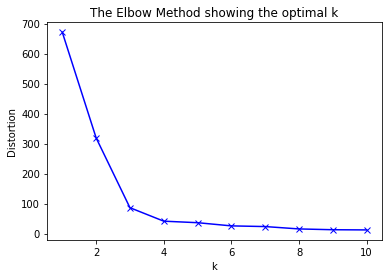

In [104]:
elbowPlot(10, X_treino, 10)

### Verificação de número de clusteres para tarefa proposta pelo grupo

Mean  1 :  633.17816079293
Mean  2 :  222.13976204644908
Mean  3 :  146.9392914953058
Mean  4 :  121.10054639830793
Mean  5 :  75.11278261113954
Mean  6 :  44.984301182143184
Mean  7 :  68.37739635866131
Mean  8 :  35.74928059537479
Mean  9 :  35.25901104771115
Mean  10 :  28.69167868055929


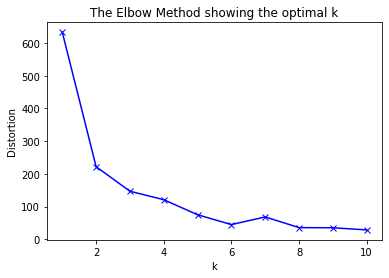

In [125]:
elbowPlot(10, W_treino, 12)

### Treinamento do Modelo K-Means
&emsp;Para a execução do modelo K-Means, utilizamos como padrão a inicialização kmeans++, porém exibimos abaixo a comparação entre as inicializações Forgy e kmeans++. \
&emsp;Podemos observar que a inicialização kmeans++ converge com mais eficiência que a Forgy, precisando de menos passos para encontrar as posições finais dos centroides, e tende a ter menos erros de inicialização, escolhendo melhor os primeiros centroides. \


[1.33451909 0.49150872]
[1.60693983 1.23984646]
[-0.60022408 -0.75773251]


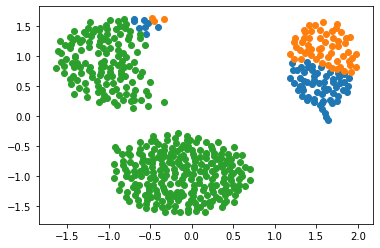

[1.45127083 0.53375359]
[1.55690336 1.14328675]
[-0.34448216 -0.61892793]


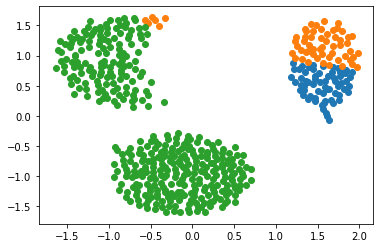

[1.53466494 0.55789352]
[1.55690336 1.14328675]
[-0.33892256 -0.5646131 ]


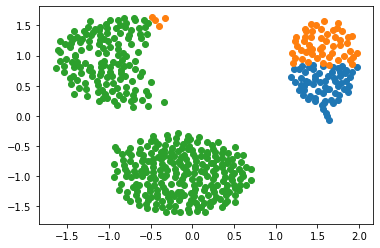

[1.590261   0.47340377]
[1.55690336 1.14328675]
[-0.33892256 -0.5646131 ]


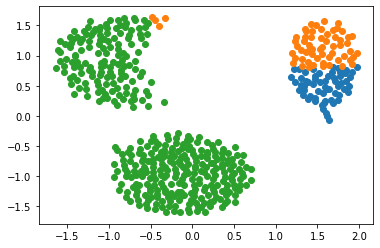

[1.590261   0.47340377]
[1.52910533 1.11311184]
[-0.33892256 -0.5646131 ]


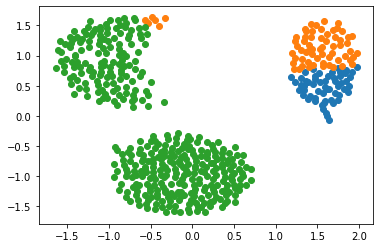

[1.590261   0.47340377]
[1.52910533 1.11311184]
[-0.33892256 -0.5646131 ]


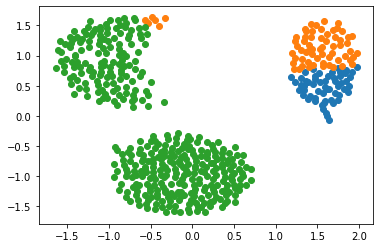

[1.590261   0.47340377]
[1.52910533 1.11311184]
[-0.33892256 -0.5646131 ]


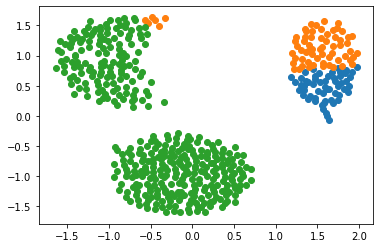

[1.590261   0.47340377]
[1.52910533 1.11311184]
[-0.33892256 -0.5646131 ]


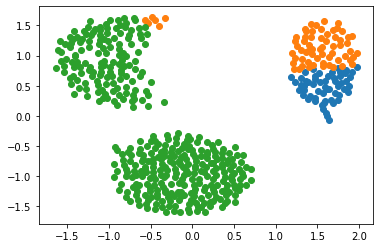

[1.590261   0.47340377]
[1.52910533 1.11311184]
[-0.33892256 -0.5646131 ]


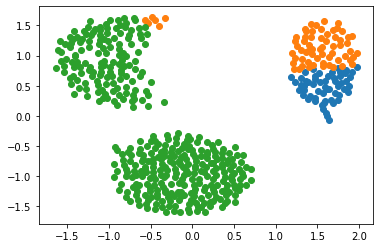

[1.590261   0.47340377]
[1.52910533 1.11311184]
[-0.33892256 -0.5646131 ]


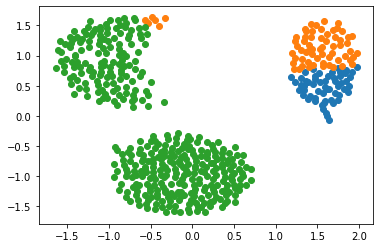

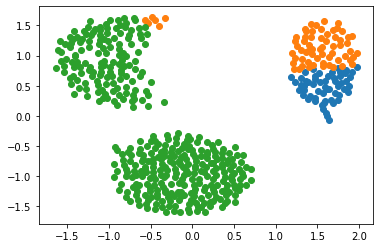

In [126]:
X_centroids, clusterMap = kmeans(3,X_treino, 10, init_mode="forgy")

[-0.25552846 -1.28881091]
[-0.81704874  0.82343272]
[1.75704921 0.34063417]


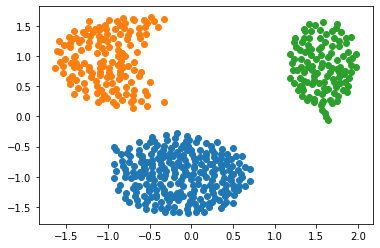

[-0.09429986 -0.98706182]
[-1.06167144  0.91395744]
[1.56246297 0.82343272]


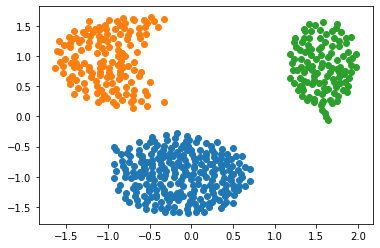

[-0.09429986 -0.98706182]
[-1.06167144  0.91395744]
[1.56246297 0.82343272]


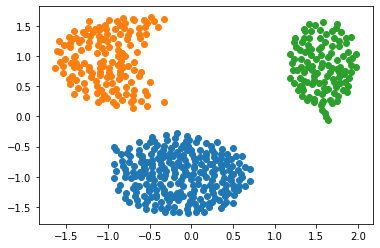

[-0.09429986 -0.98706182]
[-1.06167144  0.91395744]
[1.56246297 0.82343272]


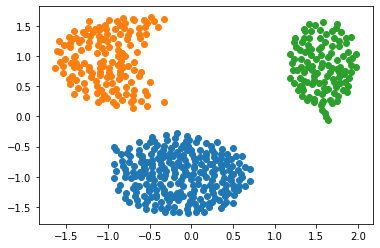

[-0.09429986 -0.98706182]
[-1.06167144  0.91395744]
[1.56246297 0.82343272]


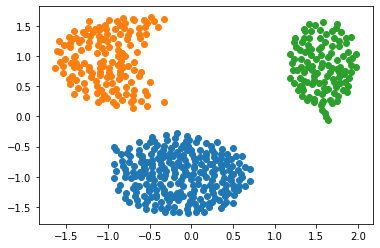

[-0.09429986 -0.98706182]
[-1.06167144  0.91395744]
[1.56246297 0.82343272]


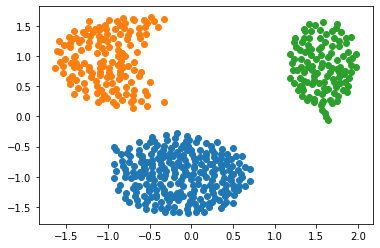

[-0.09429986 -0.98706182]
[-1.06167144  0.91395744]
[1.56246297 0.82343272]


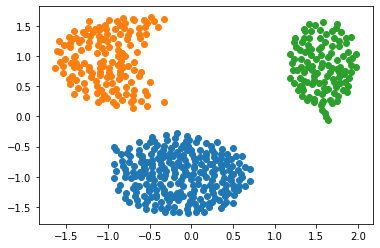

[-0.09429986 -0.98706182]
[-1.06167144  0.91395744]
[1.56246297 0.82343272]


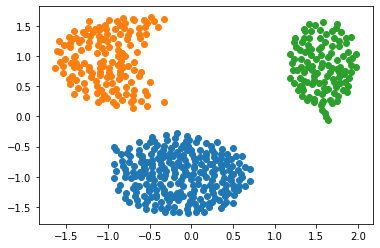

[-0.09429986 -0.98706182]
[-1.06167144  0.91395744]
[1.56246297 0.82343272]


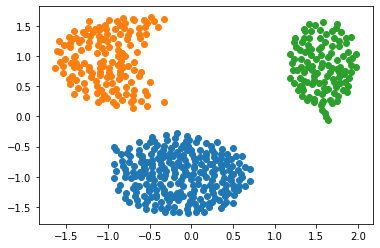

[-0.09429986 -0.98706182]
[-1.06167144  0.91395744]
[1.56246297 0.82343272]


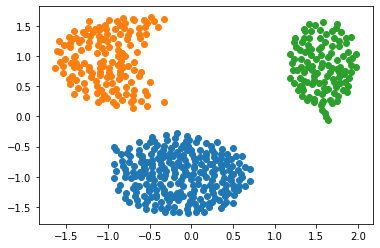

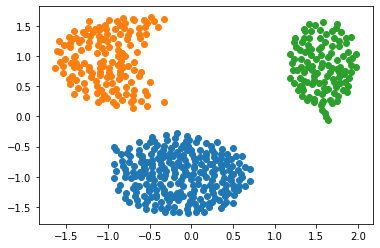

In [127]:
X_centroids, clusterMap = kmeans(3,X_treino, 10, init_mode="kmeans++")

[-0.18605311 -0.66099274  0.56103322 -0.50896619 -0.33292168  0.2962513
  0.34208192 -0.82071924 -0.22934584 -0.48797782  0.58154421  1.43831115
  0.85378424]
[ 0.59216382 -0.47248348  0.15894572  0.30180329  0.01814502  0.64876424
  0.95450162 -0.82071924  0.47148781  0.01812906  0.36217728  1.2123203
  0.55125733]
[ 0.34511082 -0.62508622  1.73074231 -1.19962167  0.72027843  0.48853108
  0.6533116  -0.17609475 -0.40455426 -0.19815593  0.58154421  0.23773476
  0.42387759]


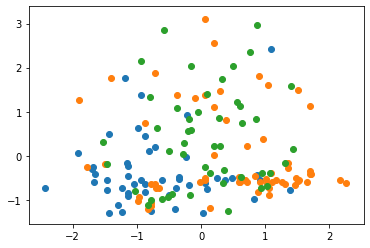

[-9.27212090e-01 -5.44296535e-01 -9.01103141e-01 -1.48624201e-01
 -1.38612179e+00 -1.03368389e+00  7.33234123e-04  6.56394314e-02
  6.85084581e-02 -7.17239912e-01  1.86683727e-01  7.88587455e-01
 -7.54385098e-01]
[ 0.59216382 -0.47248348  0.15894572  0.30180329  0.01814502  0.64876424
  0.95450162 -0.82071924  0.47148781  0.01812906  0.36217728  1.2123203
  0.55125733]
[ 0.85156946  0.82912808  0.63414004  0.15166079  0.50963841 -0.74526421
 -1.47509785  1.11315422 -1.38572137  0.35553365  0.01119018 -1.11821035
 -0.21302116]


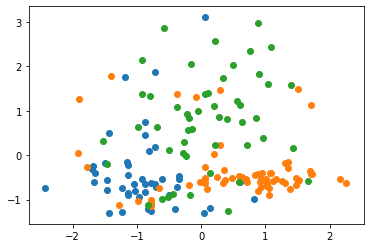

[-9.27212090e-01 -5.44296535e-01 -9.01103141e-01 -1.48624201e-01
 -1.38612179e+00 -1.03368389e+00  7.33234123e-04  6.56394314e-02
  6.85084581e-02 -7.17239912e-01  1.86683727e-01  7.88587455e-01
 -7.54385098e-01]
[ 0.59216382 -0.47248348  0.15894572  0.30180329  0.01814502  0.64876424
  0.95450162 -0.82071924  0.47148781  0.01812906  0.36217728  1.2123203
  0.55125733]
[ 0.39452142  0.81117481  0.0492855   0.60208828 -0.5435617  -0.58503105
 -1.2743045   0.71026392 -0.59728351  1.4542614  -1.78761869 -1.40069891
 -0.30855597]


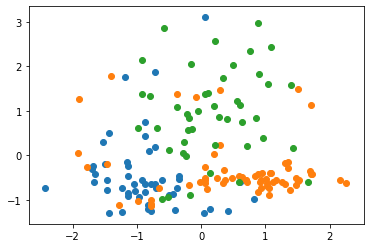

[-9.27212090e-01 -5.44296535e-01 -9.01103141e-01 -1.48624201e-01
 -1.38612179e+00 -1.03368389e+00  7.33234123e-04  6.56394314e-02
  6.85084581e-02 -7.17239912e-01  1.86683727e-01  7.88587455e-01
 -7.54385098e-01]
[ 0.59216382 -0.47248348  0.15894572  0.30180329  0.01814502  0.64876424
  0.95450162 -0.82071924  0.47148781  0.01812906  0.36217728  1.2123203
  0.55125733]
[ 0.39452142  0.81117481  0.0492855   0.60208828 -0.5435617  -0.58503105
 -1.2743045   0.71026392 -0.59728351  1.4542614  -1.78761869 -1.40069891
 -0.30855597]


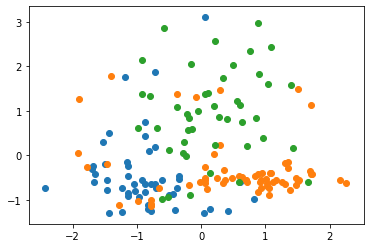

[-9.27212090e-01 -5.44296535e-01 -9.01103141e-01 -1.48624201e-01
 -1.38612179e+00 -1.03368389e+00  7.33234123e-04  6.56394314e-02
  6.85084581e-02 -7.17239912e-01  1.86683727e-01  7.88587455e-01
 -7.54385098e-01]
[ 0.59216382 -0.47248348  0.15894572  0.30180329  0.01814502  0.64876424
  0.95450162 -0.82071924  0.47148781  0.01812906  0.36217728  1.2123203
  0.55125733]
[ 0.39452142  0.81117481  0.0492855   0.60208828 -0.5435617  -0.58503105
 -1.2743045   0.71026392 -0.59728351  1.4542614  -1.78761869 -1.40069891
 -0.30855597]


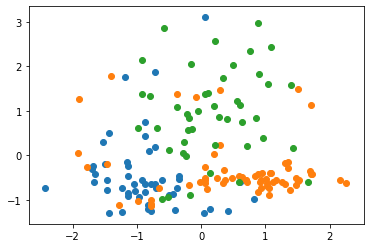

[-9.27212090e-01 -5.44296535e-01 -9.01103141e-01 -1.48624201e-01
 -1.38612179e+00 -1.03368389e+00  7.33234123e-04  6.56394314e-02
  6.85084581e-02 -7.17239912e-01  1.86683727e-01  7.88587455e-01
 -7.54385098e-01]
[ 0.59216382 -0.47248348  0.15894572  0.30180329  0.01814502  0.64876424
  0.95450162 -0.82071924  0.47148781  0.01812906  0.36217728  1.2123203
  0.55125733]
[ 0.39452142  0.81117481  0.0492855   0.60208828 -0.5435617  -0.58503105
 -1.2743045   0.71026392 -0.59728351  1.4542614  -1.78761869 -1.40069891
 -0.30855597]


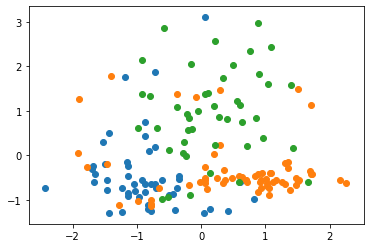

[-9.27212090e-01 -5.44296535e-01 -9.01103141e-01 -1.48624201e-01
 -1.38612179e+00 -1.03368389e+00  7.33234123e-04  6.56394314e-02
  6.85084581e-02 -7.17239912e-01  1.86683727e-01  7.88587455e-01
 -7.54385098e-01]
[ 0.59216382 -0.47248348  0.15894572  0.30180329  0.01814502  0.64876424
  0.95450162 -0.82071924  0.47148781  0.01812906  0.36217728  1.2123203
  0.55125733]
[ 0.39452142  0.81117481  0.0492855   0.60208828 -0.5435617  -0.58503105
 -1.2743045   0.71026392 -0.59728351  1.4542614  -1.78761869 -1.40069891
 -0.30855597]


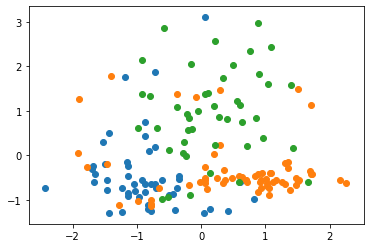

[-9.27212090e-01 -5.44296535e-01 -9.01103141e-01 -1.48624201e-01
 -1.38612179e+00 -1.03368389e+00  7.33234123e-04  6.56394314e-02
  6.85084581e-02 -7.17239912e-01  1.86683727e-01  7.88587455e-01
 -7.54385098e-01]
[ 0.59216382 -0.47248348  0.15894572  0.30180329  0.01814502  0.64876424
  0.95450162 -0.82071924  0.47148781  0.01812906  0.36217728  1.2123203
  0.55125733]
[ 0.39452142  0.81117481  0.0492855   0.60208828 -0.5435617  -0.58503105
 -1.2743045   0.71026392 -0.59728351  1.4542614  -1.78761869 -1.40069891
 -0.30855597]


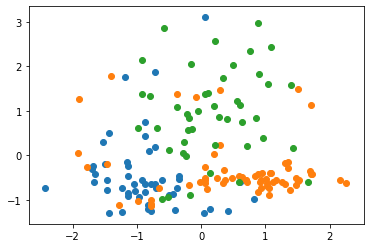

[-9.27212090e-01 -5.44296535e-01 -9.01103141e-01 -1.48624201e-01
 -1.38612179e+00 -1.03368389e+00  7.33234123e-04  6.56394314e-02
  6.85084581e-02 -7.17239912e-01  1.86683727e-01  7.88587455e-01
 -7.54385098e-01]
[ 0.59216382 -0.47248348  0.15894572  0.30180329  0.01814502  0.64876424
  0.95450162 -0.82071924  0.47148781  0.01812906  0.36217728  1.2123203
  0.55125733]
[ 0.39452142  0.81117481  0.0492855   0.60208828 -0.5435617  -0.58503105
 -1.2743045   0.71026392 -0.59728351  1.4542614  -1.78761869 -1.40069891
 -0.30855597]


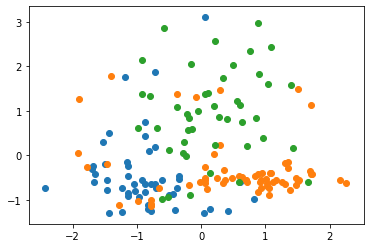

[-9.27212090e-01 -5.44296535e-01 -9.01103141e-01 -1.48624201e-01
 -1.38612179e+00 -1.03368389e+00  7.33234123e-04  6.56394314e-02
  6.85084581e-02 -7.17239912e-01  1.86683727e-01  7.88587455e-01
 -7.54385098e-01]
[ 0.59216382 -0.47248348  0.15894572  0.30180329  0.01814502  0.64876424
  0.95450162 -0.82071924  0.47148781  0.01812906  0.36217728  1.2123203
  0.55125733]
[ 0.39452142  0.81117481  0.0492855   0.60208828 -0.5435617  -0.58503105
 -1.2743045   0.71026392 -0.59728351  1.4542614  -1.78761869 -1.40069891
 -0.30855597]


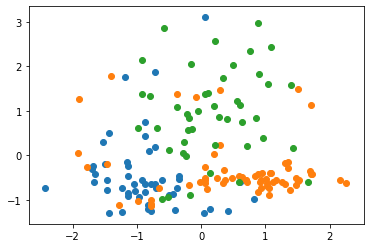

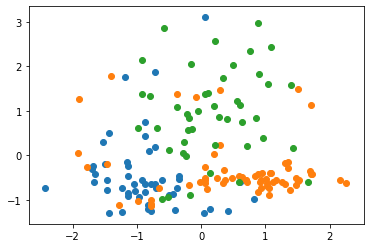

In [131]:
W_centroids, clusterMap = kmeans(3,W_treino, 10, init_mode="forgy")

[-0.92721209  2.13971627  0.63414004  0.45194578 -0.75420173 -1.4663134
 -1.56545485  1.3548884  -1.38572137 -0.52258342 -0.91015095 -1.89505389
 -0.08564141]
[-0.71721705  1.87939396  1.32865481  2.10351324  0.1585717  -0.15240153
  0.10112991  0.5491078   0.20867519 -1.28823229 -0.16430337  0.71796531
 -1.21613669]
[ 0.96274331  0.3802965  -0.24314178  0.75223078 -0.68398839 -1.51438335
 -1.35462184  0.38795167 -0.98274202  1.95604258 -1.12951789 -1.31595234
 -0.42001326]


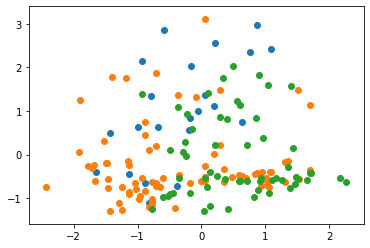

[-0.18605311  0.83810471  0.78035368  0.75223078  0.43942506 -1.03368389
 -1.43493918  1.91893483 -1.10538791  0.22576265 -0.38367031 -0.70860193
 -0.56331547]
[ 0.59216382 -0.47248348  0.15894572  0.30180329  0.01814502  0.64876424
  0.95450162 -0.82071924  0.47148781  0.01812906  0.36217728  1.2123203
  0.55125733]
[ 0.39452142  0.81117481  0.0492855   0.60208828 -0.5435617  -0.58503105
 -1.2743045   0.71026392 -0.59728351  1.4542614  -1.78761869 -1.40069891
 -0.30855597]


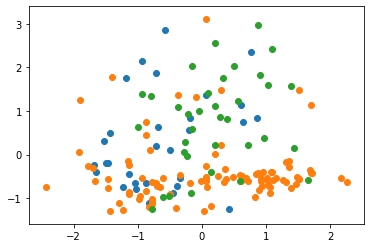

[-0.18605311  0.83810471  0.78035368  0.75223078  0.43942506 -1.03368389
 -1.43493918  1.91893483 -1.10538791  0.22576265 -0.38367031 -0.70860193
 -0.56331547]
[ 0.59216382 -0.47248348  0.15894572  0.30180329  0.01814502  0.64876424
  0.95450162 -0.82071924  0.47148781  0.01812906  0.36217728  1.2123203
  0.55125733]
[ 0.39452142  0.81117481  0.0492855   0.60208828 -0.5435617  -0.58503105
 -1.2743045   0.71026392 -0.59728351  1.4542614  -1.78761869 -1.40069891
 -0.30855597]


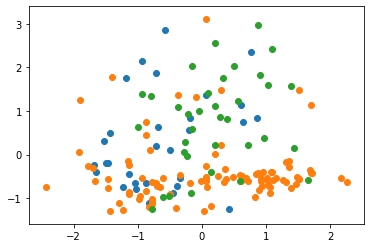

[-0.18605311  0.83810471  0.78035368  0.75223078  0.43942506 -1.03368389
 -1.43493918  1.91893483 -1.10538791  0.22576265 -0.38367031 -0.70860193
 -0.56331547]
[ 0.59216382 -0.47248348  0.15894572  0.30180329  0.01814502  0.64876424
  0.95450162 -0.82071924  0.47148781  0.01812906  0.36217728  1.2123203
  0.55125733]
[ 0.39452142  0.81117481  0.0492855   0.60208828 -0.5435617  -0.58503105
 -1.2743045   0.71026392 -0.59728351  1.4542614  -1.78761869 -1.40069891
 -0.30855597]


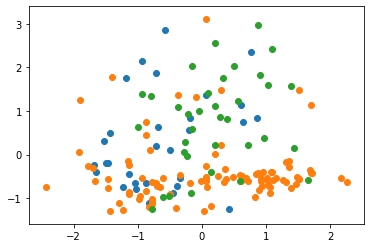

[-0.18605311  0.83810471  0.78035368  0.75223078  0.43942506 -1.03368389
 -1.43493918  1.91893483 -1.10538791  0.22576265 -0.38367031 -0.70860193
 -0.56331547]
[ 0.59216382 -0.47248348  0.15894572  0.30180329  0.01814502  0.64876424
  0.95450162 -0.82071924  0.47148781  0.01812906  0.36217728  1.2123203
  0.55125733]
[ 0.39452142  0.81117481  0.0492855   0.60208828 -0.5435617  -0.58503105
 -1.2743045   0.71026392 -0.59728351  1.4542614  -1.78761869 -1.40069891
 -0.30855597]


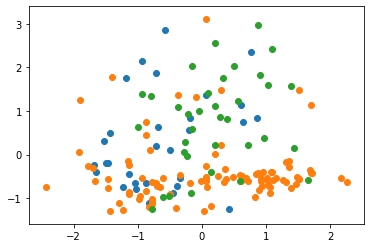

[-0.18605311  0.83810471  0.78035368  0.75223078  0.43942506 -1.03368389
 -1.43493918  1.91893483 -1.10538791  0.22576265 -0.38367031 -0.70860193
 -0.56331547]
[ 0.59216382 -0.47248348  0.15894572  0.30180329  0.01814502  0.64876424
  0.95450162 -0.82071924  0.47148781  0.01812906  0.36217728  1.2123203
  0.55125733]
[ 0.39452142  0.81117481  0.0492855   0.60208828 -0.5435617  -0.58503105
 -1.2743045   0.71026392 -0.59728351  1.4542614  -1.78761869 -1.40069891
 -0.30855597]


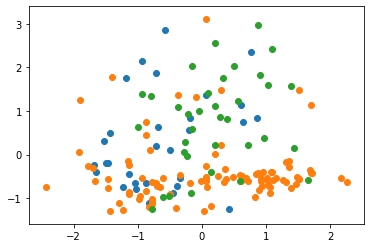

[-0.18605311  0.83810471  0.78035368  0.75223078  0.43942506 -1.03368389
 -1.43493918  1.91893483 -1.10538791  0.22576265 -0.38367031 -0.70860193
 -0.56331547]
[ 0.59216382 -0.47248348  0.15894572  0.30180329  0.01814502  0.64876424
  0.95450162 -0.82071924  0.47148781  0.01812906  0.36217728  1.2123203
  0.55125733]
[ 0.39452142  0.81117481  0.0492855   0.60208828 -0.5435617  -0.58503105
 -1.2743045   0.71026392 -0.59728351  1.4542614  -1.78761869 -1.40069891
 -0.30855597]


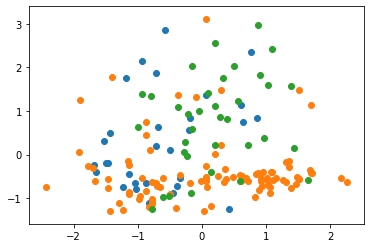

[-0.18605311  0.83810471  0.78035368  0.75223078  0.43942506 -1.03368389
 -1.43493918  1.91893483 -1.10538791  0.22576265 -0.38367031 -0.70860193
 -0.56331547]
[ 0.59216382 -0.47248348  0.15894572  0.30180329  0.01814502  0.64876424
  0.95450162 -0.82071924  0.47148781  0.01812906  0.36217728  1.2123203
  0.55125733]
[ 0.39452142  0.81117481  0.0492855   0.60208828 -0.5435617  -0.58503105
 -1.2743045   0.71026392 -0.59728351  1.4542614  -1.78761869 -1.40069891
 -0.30855597]


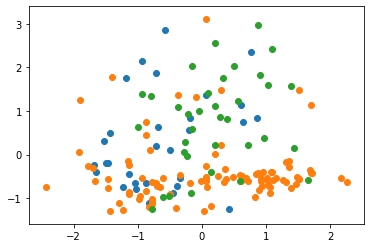

[-0.18605311  0.83810471  0.78035368  0.75223078  0.43942506 -1.03368389
 -1.43493918  1.91893483 -1.10538791  0.22576265 -0.38367031 -0.70860193
 -0.56331547]
[ 0.59216382 -0.47248348  0.15894572  0.30180329  0.01814502  0.64876424
  0.95450162 -0.82071924  0.47148781  0.01812906  0.36217728  1.2123203
  0.55125733]
[ 0.39452142  0.81117481  0.0492855   0.60208828 -0.5435617  -0.58503105
 -1.2743045   0.71026392 -0.59728351  1.4542614  -1.78761869 -1.40069891
 -0.30855597]


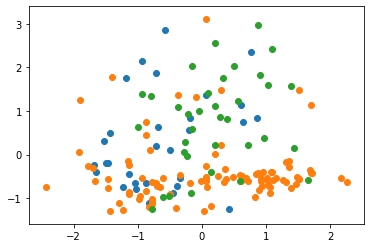

[-0.18605311  0.83810471  0.78035368  0.75223078  0.43942506 -1.03368389
 -1.43493918  1.91893483 -1.10538791  0.22576265 -0.38367031 -0.70860193
 -0.56331547]
[ 0.59216382 -0.47248348  0.15894572  0.30180329  0.01814502  0.64876424
  0.95450162 -0.82071924  0.47148781  0.01812906  0.36217728  1.2123203
  0.55125733]
[ 0.39452142  0.81117481  0.0492855   0.60208828 -0.5435617  -0.58503105
 -1.2743045   0.71026392 -0.59728351  1.4542614  -1.78761869 -1.40069891
 -0.30855597]


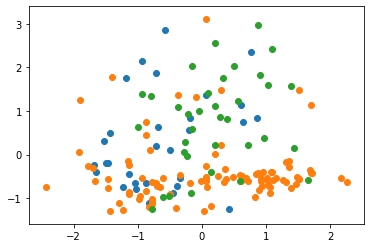

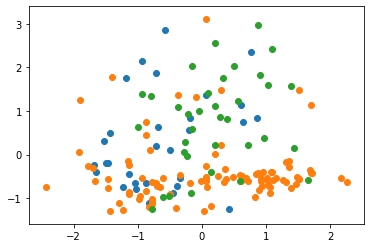

In [171]:
W_centroids, clusterMap = kmeans(3,W_treino, 10, init_mode="kmeans++")

### Treinamento do Modelo Agglometrative Hierarchical Clustering
&emsp;Realizamos a etapa inicial de treinamento do Agg.H.C. definido apenas um cluster de saída, com a finalidade de construir o dendrograma (como explicado anteriormente). 

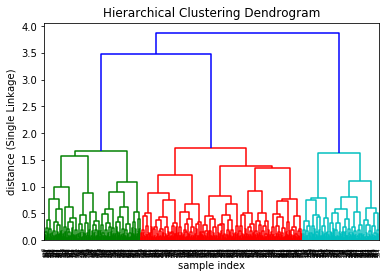

In [108]:
X_pointsMap = agglomerativeHierarchicalCluster(X_treino, 1, "complete")

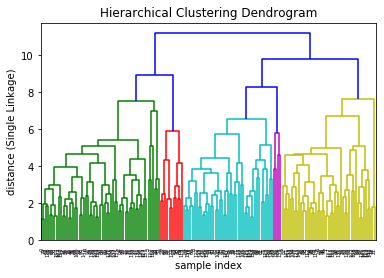

In [109]:
W_pointsMap = agglomerativeHierarchicalCluster(W_treino, 1, "complete")

### Testando Modelo K-Means
&emsp;Podemos observar que o modelo encontrou os clusteres da tarefa 2D com facilidade, tendo 100% de acerto. \
&emsp;Enquanto que na tarefa proposta pelo grupo, o modelo teve uma taxa de acerto em torno de 14/18 (79,2%).

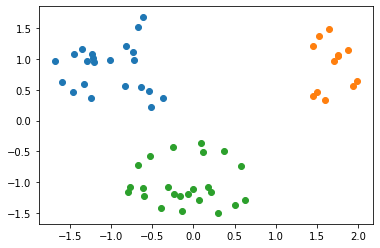

In [110]:
kmeans(3,X_teste, 10, 'test', X_centroids)

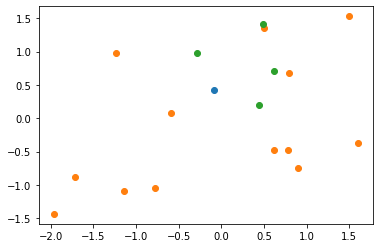

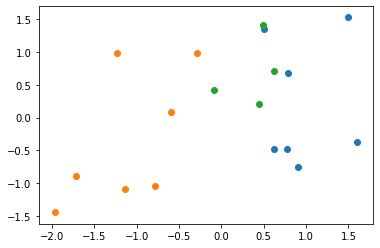

In [172]:
kmeans(3,W_teste, 10, 'test', W_centroids)

plotGroundTruth(3, W_teste, W_teste_y)

### Testando Modelo Agglomerative Hierarchical Clustering
&emsp;Podemos observar que o modelo atribuiu corretamente os clusteres para os dados de teste, com 100% de acertividade. \
&emsp;Enquanto que na tarefa proposta pelo grupo, o modelo teve uma taxa de acerto em torno de 12/18 (66,6%).

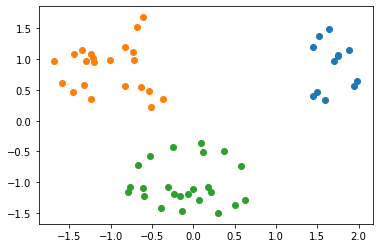

In [112]:
X_pointsMap = agglomerativeHierarchicalCluster(X_treino, 3, "complete", False)
testPointsMap = testAgglomerativeHierarchicalCluster(X_teste, X_treino, X_pointsMap)
plotAggCluster(testPointsMap, X_teste)

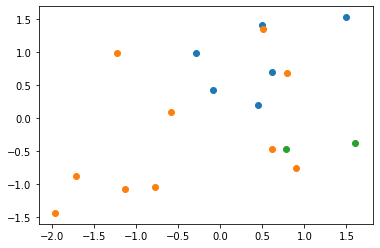

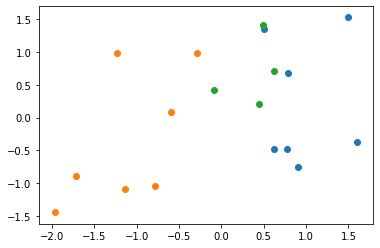

In [114]:
W_pointsMap = agglomerativeHierarchicalCluster(W_treino, 3, "complete", False)
testPointsMap = testAgglomerativeHierarchicalCluster(W_teste, W_treino, W_pointsMap)
plotAggCluster(testPointsMap, W_teste)
plotGroundTruth(3, W_teste, W_teste_y)

### Discussões Parte 1

 - **Normalização**:
Percebemos a importância de normalizar os dados antes de serem utilizados pelo modelo, pois de outra forma, teriamos resultados enviesados e dificuldade em fazer o modelo convergir. Este problema é mais visível nos dados da tarefa 2D, onde as grandezas das duas features são bem diferentes, mas na base de dados de Vinhos (proposta pelo grupo), esta diferença nas grandezas não é tão acentuada, o que causaria vieses menores, porém perceptíveis e que atrapalhariam bastante o modelo. 



- **Número de clusteres encontrados**: \
&emsp;&emsp;- **K-Means**: O número de clusteres encontrado para o K-Means, tanto na tarefa 2D quando na proposta pelo grupo, representa bem os nossos dados, como podemos observar na função cotovelo aplicada para as duas bases de dados. Sabemos que na tarefa 2D os dados são divididos em 3 grupos, e também temos a classificação dos vinhos na segunda base de dados (ground truth) que também é separada em 3 classes. Em ambas a função cotovelo foi capaz de indicar o melhor valor para k. \
&emsp;&emsp;- **Agg.H.C.**: O número de clusteres encontrado para o Agg.H.C. também representou bem nossos dados. Podemos constatar isso ao observar o dendrograma desenhado para o modelo, pois para as duas bases de dados, o gráfico indicou corretamente o melhor número para o agrupamento dos dados. 


- **Desvantagens de cada método**:\
&emsp;&emsp;- **K-Means**: Embora seja rápido, é muito dependente da inicialização dos centroides, podendo reproduzir um resultado completamente errado caso tenha uma má inicialização. Ele também é muito sensível a outliers. \
&emsp;&emsp;- **Agg.H.C.**: Uma desvantagem perceptível do modelo é o tempo que leva para finalizar a construção da árvore hierárquica, levando muito tempo quanto mais dados são fornecidos. A necessidade de atualizar as distâncias entre os clusteres contribui fortemente para a ineficiência do algoritmo. \
&emsp;&emsp;&emsp;Outro ponto é a necessidade de escolher a lógica de distâncias correta (Linkage), pois isso afeta muito o resultado do algoritmo. 

## Parte 2 - Redução de Dimensionalidade
Utilizamos o método PCA para reduzir a dimensionalidade da tarefa escolhida pelo grupo, e comparamos o efeito de aplicar o K-Means em um conjunto de dados sem redução de dimensionalidade e outro com redução de dimensionalidade.
Realizamos as seguintes tarefas:
<ul>
    <li>Rodamos o PCA nos dados, utilizando 3 energias (variâncias) diferentes para reduzir a dimensionalidade</li>
    <li>Rodamos o K-Means com diferentes números de clusteres</li>
    <li>Comparamos os resultados com os obtidos na Parte 1</li>
</ul>


### Rodando o PCA
Realizamos a análise de dimensionalidade utilizando-se dos dados de treino do dataset de vinhos, e obervarmos as propriedades mais relevantes para classificação dos itens.

Primeiramente, montamos um gráfico para explicar quais componentes principais são mais percentualmente relevantes à representação, ou seja, quais componentes explicam melhor nossos dados.


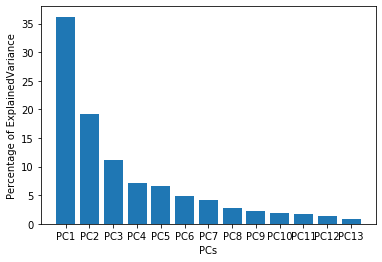

In [175]:
pca = PCA()
pca_data = pca.fit_transform(W_array)

per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
labels = ["PC" + str(i) for i in range(1, 14)]

plt.bar(x=range(1, 14), height=per_var, tick_label=labels)
plt.ylabel('Percentage of ExplainedVariance')
plt.xlabel('PCs')
plt.show()
W_treino, W_teste, W_treino_y, W_teste_y = train_test_split(pca_data, W_array_y, test_size=0.1, random_state=42)

Em seguida, montamos um dataFrame para organizar nossos dados e observar a projeção das componentes em apenas duas dimensões, para que seja mais fácil de avaliar suas relevâncias e similaridades.

É importante observar que features mais distantes da origem têm maior influência sobre os dados, como também, features próximas umas das outras nos revelam similaridade entre as mesmas.

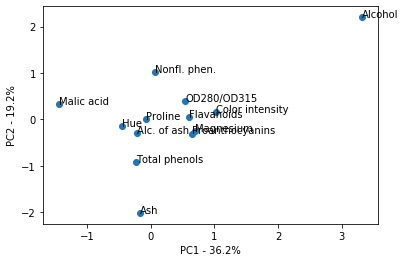

In [142]:
wine_labels = ['Alcohol', 'Malic acid', 'Ash', 'Alc. of ash', 'Magnesium', 'Total phenols', \
              'Flavanoids', 'Nonfl. phen.', 'Proanthocyanins', 'Color intensity', 'Hue', 'OD280/OD315',\
              'Proline']
pca_df = pd.DataFrame(pca_data.T, index=wine_labels)


plt.scatter(pca_df[0], pca_df[1])
plt.xlabel('PC1 - {0}%'.format(per_var[0]))
plt.ylabel('PC2 - {0}%'.format(per_var[1]))

for idx in pca_df.index:
    plt.annotate(idx, (pca_df[0].loc[idx], pca_df[1].loc[idx]))

plt.show()

### Escolher 3 variâncias
Variância 1: PC1, PC2 e PC3 com 66.52% de representatividade <br>
Variância 2: PC1, PC2, PC3, PC4 e PC5 com 80.16% de representatividade <br>
Variância 3: PC1, PC2, PC3, PC4, PC5, PC6 e PC7 com 89.33% de representatividade <br>

In [149]:
energy1 = 3
energy2 = 5
energy3 = 7


cluster_energy2 = []
cluster_energy3 = []

Mean  1 :  461.8070860894695
Mean  2 :  157.27576162382718
Mean  3 :  83.57565655732681
Mean  4 :  60.68278762007308
Mean  5 :  51.915557043691635
Mean  6 :  28.14366269142898
Mean  7 :  20.381608238902565
Mean  8 :  20.427121437727564
Mean  9 :  16.922395526670453
Mean  10 :  9.787673061305068


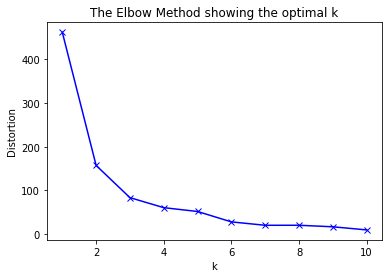

In [150]:
elbowPlot(10, W_treino[:,:energy1])

Mean  1 :  533.0975822699776
Mean  2 :  243.95968711971582
Mean  3 :  76.79824097387583
Mean  4 :  89.94352252605867
Mean  5 :  40.0356339200532
Mean  6 :  42.05000276609108
Mean  7 :  32.003185518326696
Mean  8 :  31.369638968288047
Mean  9 :  21.75141540563453
Mean  10 :  26.333232999269836


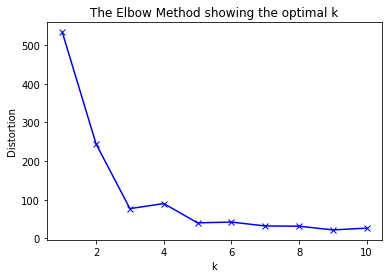

In [151]:
elbowPlot(10, W_treino[:,:energy2])

Mean  1 :  578.1301103495123
Mean  2 :  230.34823243752163
Mean  3 :  107.4739874992924
Mean  4 :  80.17502476573914
Mean  5 :  73.68412837344916
Mean  6 :  75.4770721514117
Mean  7 :  41.734920367368204
Mean  8 :  45.51665265815161
Mean  9 :  24.756234450519262
Mean  10 :  42.27263449637137


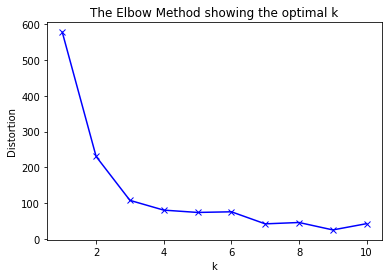

In [152]:
elbowPlot(10, W_treino[:,:energy3])

[-1.34928528  2.11800147 -0.04765232]
[ 2.25190942  1.43274138 -0.23020824]
[ 1.90269086 -1.63306043  1.17208212]


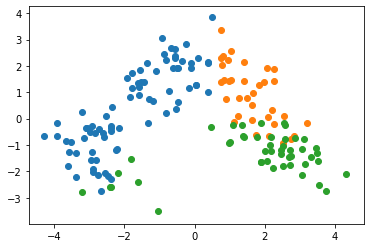

[-2.14681113 -0.36825495 -0.4533013 ]
[1.42056925 1.41820664 0.13927583]
[ 2.17374092 -1.21219984  0.26177959]


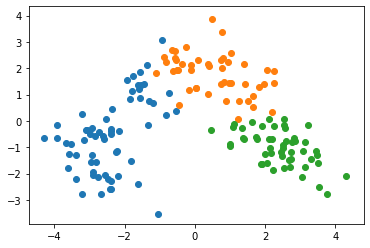

[-2.3751947  -0.48233372 -0.25288399]
[ 0.78790461  2.02662652 -0.2547234 ]
[ 2.58809543 -0.7796163  -0.11847747]


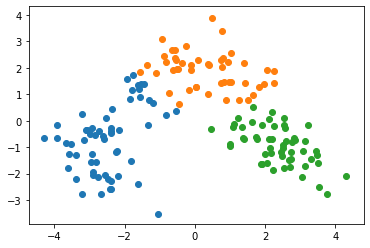

[-2.3751947  -0.48233372 -0.25288399]
[-0.09680973  2.10999799  0.43482612]
[ 2.58809543 -0.7796163  -0.11847747]


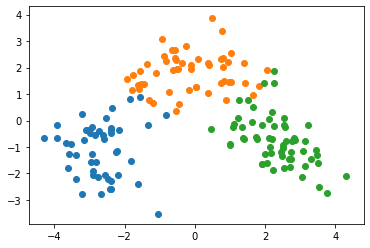

[-2.80706372 -1.57053379 -0.47252793]
[-0.09680973  2.10999799  0.43482612]
[ 2.58809543 -0.7796163  -0.11847747]


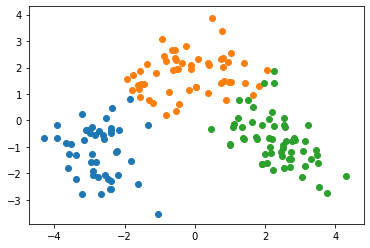

[-2.80706372 -1.57053379 -0.47252793]
[-0.09680973  2.10999799  0.43482612]
[ 2.58809543 -0.7796163  -0.11847747]


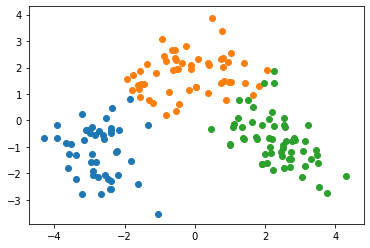

[-2.80706372 -1.57053379 -0.47252793]
[-0.09680973  2.10999799  0.43482612]
[ 2.58809543 -0.7796163  -0.11847747]


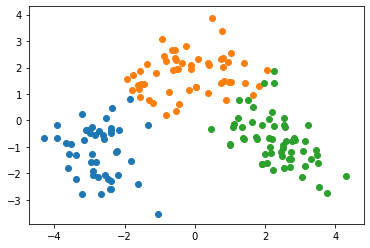

[-2.80706372 -1.57053379 -0.47252793]
[-0.09680973  2.10999799  0.43482612]
[ 2.58809543 -0.7796163  -0.11847747]


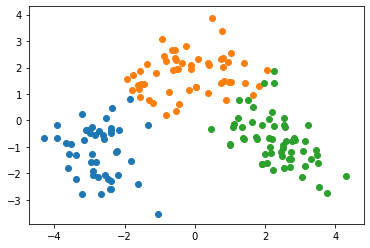

[-2.80706372 -1.57053379 -0.47252793]
[-0.09680973  2.10999799  0.43482612]
[ 2.58809543 -0.7796163  -0.11847747]


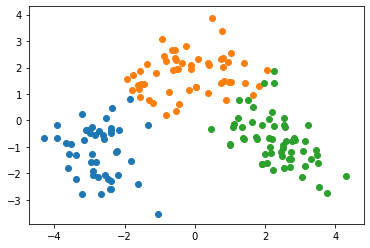

[-2.80706372 -1.57053379 -0.47252793]
[-0.09680973  2.10999799  0.43482612]
[ 2.58809543 -0.7796163  -0.11847747]


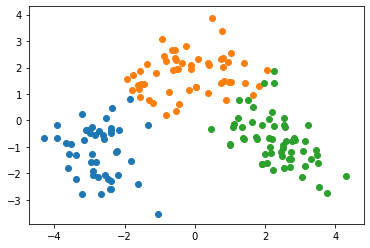

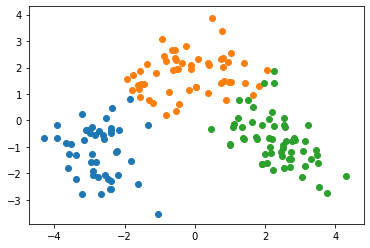

In [154]:
cluster_energy1, clusterMap = kmeans(3, W_treino[:,:energy1])

[-2.38092779 -2.58866743  1.41804403  0.58850194  1.12799681]
[-0.54395259  0.36892655  1.30889593 -1.27799856  3.34679072]
[ 2.18840633 -0.68956962  1.39456688 -0.77749181 -0.81058407]


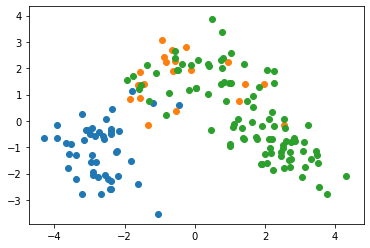

[-2.80706372 -1.57053379 -0.47252793  0.62735845 -0.260173  ]
[-1.45737704  1.38335177 -0.2273069  -0.69635687  1.06736218]
[ 1.64498834  0.51627893  0.14388509 -0.41372002 -0.37571996]


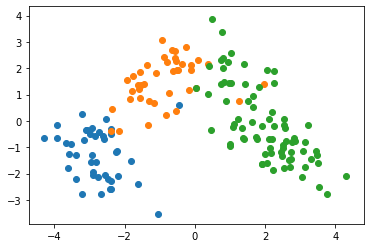

[-2.80706372 -1.57053379 -0.47252793  0.62735845 -0.260173  ]
[-0.72537239  1.0636454   0.08033223 -0.07601943 -0.18016577]
[ 1.90382623 -0.17671095  0.45083504  0.28411355 -0.16294945]


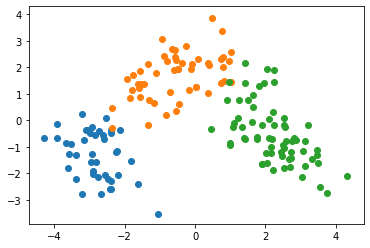

[-2.80706372 -1.57053379 -0.47252793  0.62735845 -0.260173  ]
[-0.72537239  1.0636454   0.08033223 -0.07601943 -0.18016577]
[ 2.00985085 -1.24702946 -0.05729399  0.23064311 -0.38465107]


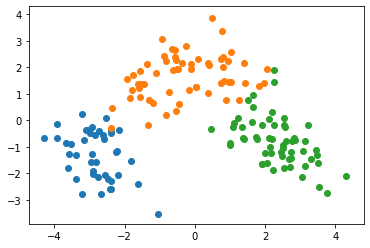

[-2.80706372 -1.57053379 -0.47252793  0.62735845 -0.260173  ]
[-0.72537239  1.0636454   0.08033223 -0.07601943 -0.18016577]
[ 2.00985085 -1.24702946 -0.05729399  0.23064311 -0.38465107]


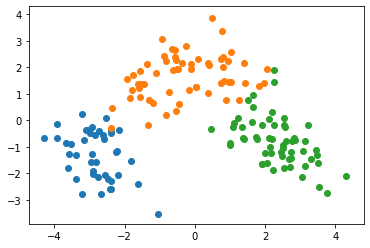

[-2.80706372 -1.57053379 -0.47252793  0.62735845 -0.260173  ]
[-0.72537239  1.0636454   0.08033223 -0.07601943 -0.18016577]
[ 2.00985085 -1.24702946 -0.05729399  0.23064311 -0.38465107]


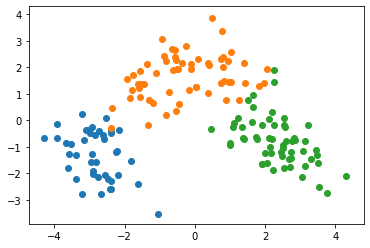

[-2.80706372 -1.57053379 -0.47252793  0.62735845 -0.260173  ]
[-0.72537239  1.0636454   0.08033223 -0.07601943 -0.18016577]
[ 2.00985085 -1.24702946 -0.05729399  0.23064311 -0.38465107]


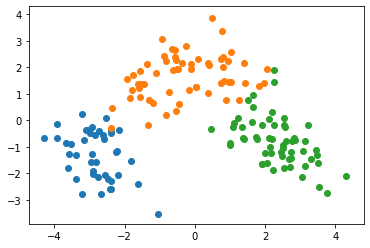

[-2.80706372 -1.57053379 -0.47252793  0.62735845 -0.260173  ]
[-0.72537239  1.0636454   0.08033223 -0.07601943 -0.18016577]
[ 2.00985085 -1.24702946 -0.05729399  0.23064311 -0.38465107]


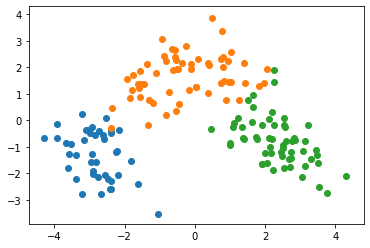

[-2.80706372 -1.57053379 -0.47252793  0.62735845 -0.260173  ]
[-0.72537239  1.0636454   0.08033223 -0.07601943 -0.18016577]
[ 2.00985085 -1.24702946 -0.05729399  0.23064311 -0.38465107]


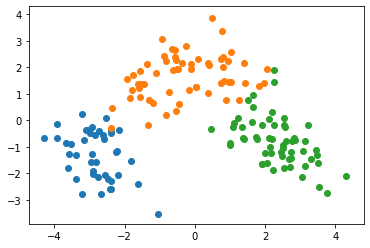

[-2.80706372 -1.57053379 -0.47252793  0.62735845 -0.260173  ]
[-0.72537239  1.0636454   0.08033223 -0.07601943 -0.18016577]
[ 2.00985085 -1.24702946 -0.05729399  0.23064311 -0.38465107]


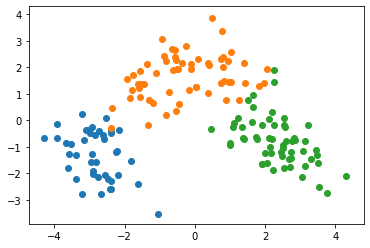

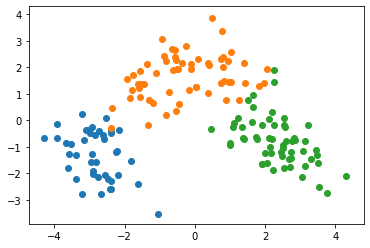

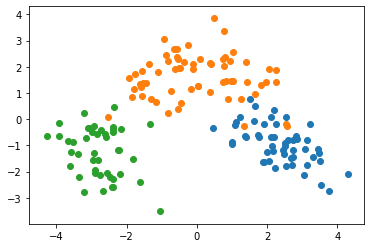

In [177]:
cluster_energy2, clusterMap = kmeans(3, W_treino[:,:energy2])

plotGroundTruth(3, W_treino, W_treino_y)

[ 2.44908967 -1.17485013 -0.97709489 -0.0658305  -1.02776191 -0.62012074
  0.05289073]
[-3.21161722  0.2512491  -0.84712915 -0.21706535  0.60909521 -0.39537773
 -0.2918493 ]
[-3.93646339 -0.65968723  1.71221542  0.5454838  -0.53732482 -0.89062318
  1.46597146]


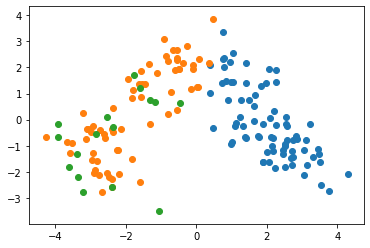

[ 1.90382623 -0.17671095  0.45083504  0.28411355 -0.16294945 -0.17464173
 -0.65782734]
[-1.62067257  1.35558339  0.287159   -0.02602455 -0.56935255  0.58116777
 -0.07761587]
[-2.37447163 -0.29198035  1.24191433 -0.74880554 -0.41557911 -0.42684748
  0.07347623]


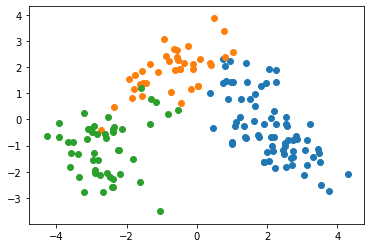

[ 1.90382623 -0.17671095  0.45083504  0.28411355 -0.16294945 -0.17464173
 -0.65782734]
[-0.36626736  2.1693533  -0.48132423  0.39840046 -0.46905131  0.19448662
 -0.24027591]
[-2.80706372 -1.57053379 -0.47252793  0.62735845 -0.260173    0.55324291
 -0.44946417]


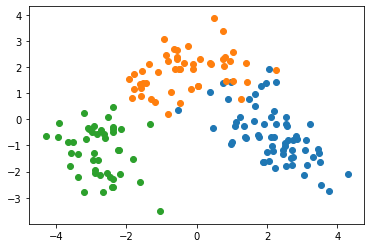

[ 2.17374092 -1.21219984  0.26177959 -0.50442609 -0.69542181 -0.25698374
 -0.21906358]
[-0.36626736  2.1693533  -0.48132423  0.39840046 -0.46905131  0.19448662
 -0.24027591]
[-2.80706372 -1.57053379 -0.47252793  0.62735845 -0.260173    0.55324291
 -0.44946417]


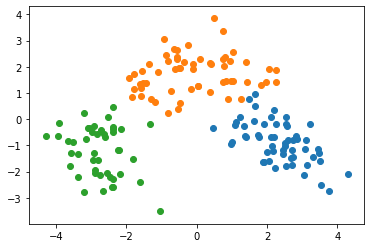

[ 2.17374092 -1.21219984  0.26177959 -0.50442609 -0.69542181 -0.25698374
 -0.21906358]
[-0.36626736  2.1693533  -0.48132423  0.39840046 -0.46905131  0.19448662
 -0.24027591]
[-2.80706372 -1.57053379 -0.47252793  0.62735845 -0.260173    0.55324291
 -0.44946417]


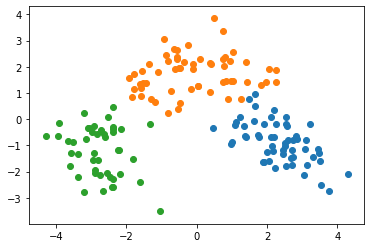

[ 2.17374092 -1.21219984  0.26177959 -0.50442609 -0.69542181 -0.25698374
 -0.21906358]
[-0.36626736  2.1693533  -0.48132423  0.39840046 -0.46905131  0.19448662
 -0.24027591]
[-2.80706372 -1.57053379 -0.47252793  0.62735845 -0.260173    0.55324291
 -0.44946417]


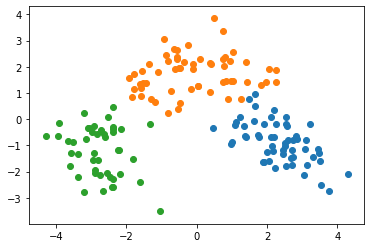

[ 2.17374092 -1.21219984  0.26177959 -0.50442609 -0.69542181 -0.25698374
 -0.21906358]
[-0.36626736  2.1693533  -0.48132423  0.39840046 -0.46905131  0.19448662
 -0.24027591]
[-2.80706372 -1.57053379 -0.47252793  0.62735845 -0.260173    0.55324291
 -0.44946417]


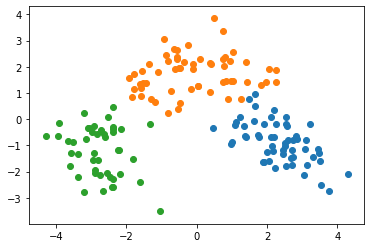

[ 2.17374092 -1.21219984  0.26177959 -0.50442609 -0.69542181 -0.25698374
 -0.21906358]
[-0.36626736  2.1693533  -0.48132423  0.39840046 -0.46905131  0.19448662
 -0.24027591]
[-2.80706372 -1.57053379 -0.47252793  0.62735845 -0.260173    0.55324291
 -0.44946417]


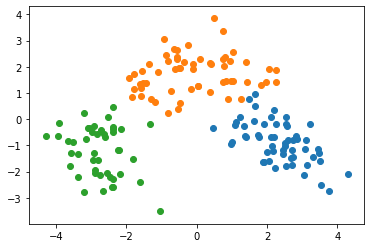

[ 2.17374092 -1.21219984  0.26177959 -0.50442609 -0.69542181 -0.25698374
 -0.21906358]
[-0.36626736  2.1693533  -0.48132423  0.39840046 -0.46905131  0.19448662
 -0.24027591]
[-2.80706372 -1.57053379 -0.47252793  0.62735845 -0.260173    0.55324291
 -0.44946417]


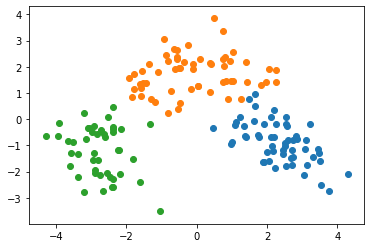

[ 2.17374092 -1.21219984  0.26177959 -0.50442609 -0.69542181 -0.25698374
 -0.21906358]
[-0.36626736  2.1693533  -0.48132423  0.39840046 -0.46905131  0.19448662
 -0.24027591]
[-2.80706372 -1.57053379 -0.47252793  0.62735845 -0.260173    0.55324291
 -0.44946417]


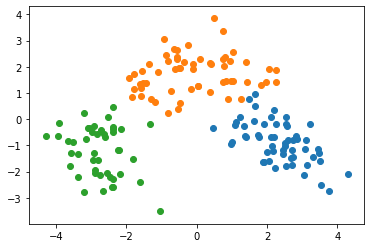

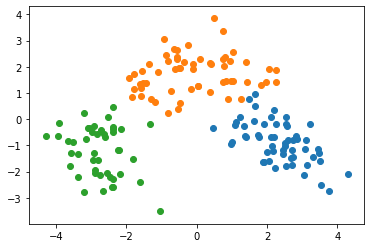

In [178]:
cluster_energy3, clusterMap = kmeans(3, W_treino[:,:energy3])

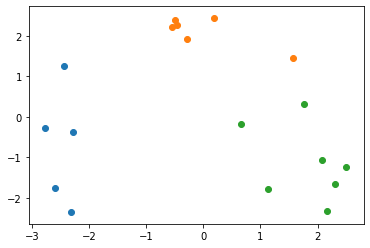

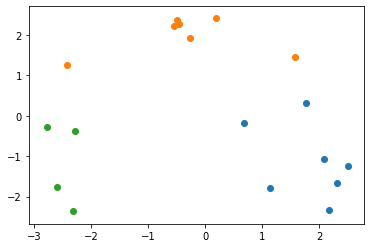

In [179]:
kmeans(3, W_teste[:,:energy1], mode="test", fixed_centroids=cluster_energy1)

plotGroundTruth(3, W_teste, W_teste_y)

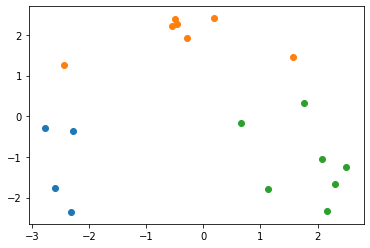

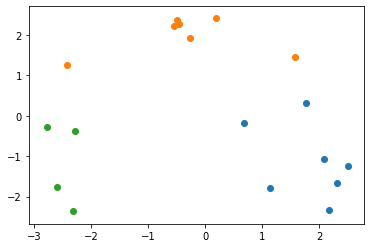

In [180]:
kmeans(3, W_teste[:,:energy2], mode="test", fixed_centroids=cluster_energy2)

plotGroundTruth(3, W_teste, W_teste_y)

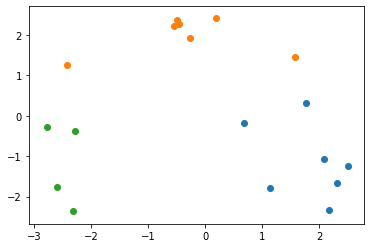

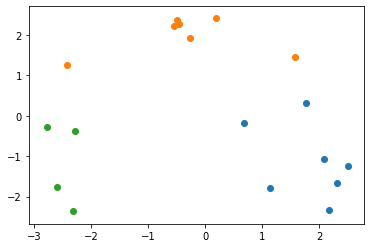

In [181]:
kmeans(3, W_teste[:,:energy3], mode="test", fixed_centroids=cluster_energy3)

plotGroundTruth(3, W_teste, W_teste_y)

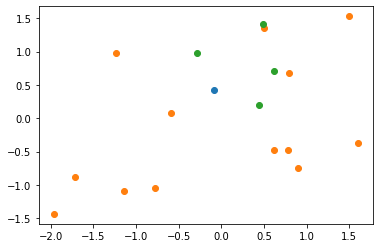

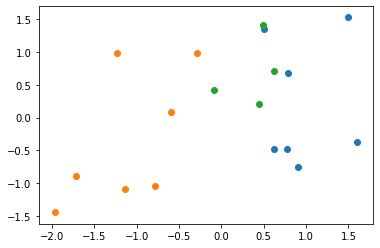

In [182]:
kmeans(3,W_teste_sem_pca, 10, 'test', W_centroids)

plotGroundTruth(3, W_teste_sem_pca, W_teste_sem_pca_y)

## Discussão
<ul>
    <li>Como/se a normalização afetou nossos reultados</li>
    <li>Se o número de clusteres encontrado representa bem nossos dados</li>
    <li>Como/se a inicialização de "centroides" afeta a solução</li>
    <li>As desvantagens de cada método</li>
    <li>Como a redução de dimensionalidade afetou seus resultados</li>
</ul>